In [1]:
import os
import requests
import zipfile
import tempfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

# Tensorflow Hub
import tensorflow_hub as hub

# Colab auth
from google.colab import auth
from google.cloud import storage

In [2]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.6.0
keras version 2.6.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Mon Oct 25 23:47:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    32W / 250W |    347MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def compute_dataset_metrics(data_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0], 
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })
  
  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = None
def create_experiment():
  global experiment_name
  experiment_name = "experiment_" + str(int(time.time()))

  # Create experiment folder
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)

def upload_experiment(data_details):
  
  # Check the logged in account
  user_account = !gcloud config get-value account
  user_account = user_account[0]
  print("user_account",user_account)

  # Check Bucket Access
  bucket_name = "ac215-mushroom-app-models" # BUCKET NAME

  # List buckets in a GCP project
  storage_client = storage.Client(project="ac215-project") # PROJECT ID 

  # Get bucket for Experiments
  bucket = storage_client.get_bucket(bucket_name)
  print("Model Bucket:",bucket)

  # Save data details used for the experiment
  save_data_details(data_details)

  # Copy the experiment folder to GCP Bucket
  for file_path in glob(experiment_name+'/*'):
    print(file_path)
    blob = bucket.blob(os.path.join(user_account,file_path)) 
    print('uploading file', file_path)
    blob.upload_from_filename(file_path)
  
  # Submit file
  submit_file = "submit.txt"
  with open(submit_file, "w") as f:
    f.write("Submission!")

  blob = bucket.blob(submit_file) 
  print('Uploading file', submit_file)
  blob = bucket.blob(os.path.join(user_account,experiment_name,submit_file)) 
  blob.upload_from_filename(submit_file)

def save_data_details(data_details):
  with open(os.path.join(experiment_name,"data_details.json"), "w") as json_file:
    json_file.write(json.dumps(data_details,cls=JsonEncoder))

# def save_model(model,model_name="model01"):

#   # Save the enitire model (structure + weights)
#   model.save(os.path.join(experiment_name,model_name+".hdf5"))

#   # Save only the weights
#   model.save_weights(os.path.join(experiment_name,model_name+".h5"))

#   # Save the structure only
#   model_json = model.to_json()
#   with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
#       json_file.write(model_json)

experiment_name = "models"
def save_model(model,model_train_history,execution_time, learning_rate, epochs, optimizer, evaluation_results):
  model_name=model.name

  # Ensure path exists
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)
  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)
  
  model_size = get_model_size(model_name=model.name)

  # Save model history
  with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
      json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

  trainable_parameters = count_params(model.trainable_weights)
  non_trainable_parameters = count_params(model.non_trainable_weights)

  # Save model metrics
  metrics ={
      "trainable_parameters":trainable_parameters,
      "execution_time":execution_time,
      "loss":evaluation_results[0],
      "accuracy":evaluation_results[1],
      "model_size":model_size,
      "learning_rate":learning_rate,
      "batch_size":batch_size,
      "epochs":epochs,
      "optimizer":type(optimizer).__name__
  }
  with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
      json_file.write(json.dumps(metrics,cls=JsonEncoder))

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".h5")).st_size
  return model_size

def append_training_history(model_train_history, prev_model_train_history):
  for metric in ["loss","val_loss","accuracy","val_accuracy"]:
    for metric_value in prev_model_train_history[metric]:
      model_train_history[metric].append(metric_value)
  
  return model_train_history

def evaluate_save_model(model,test_data, model_train_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True):
  
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
    # Save model
    save_model(model, model_name=model.name)
    model_size = get_model_size(model_name=model.name)

    # Save model history
    with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
        json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

    trainable_parameters = count_params(model.trainable_weights)
    non_trainable_parameters = count_params(model.non_trainable_weights)

    # Save model metrics
    metrics ={
        "trainable_parameters":trainable_parameters,
        "execution_time":execution_time,
        "loss":evaluation_results[0],
        "accuracy":evaluation_results[1],
        "model_size":model_size,
        "learning_rate":learning_rate,
        "batch_size":batch_size,
        "epochs":epochs,
        "optimizer":type(optimizer).__name__
    }
    with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics,cls=JsonEncoder))

def evaluate_model(model,test_data, model_train_history,execution_time, 
                      learning_rate, batch_size, epochs, optimizer,
                      save=True,
                      loss_metrics=["loss","val_loss"],
                      acc_metrics=["accuracy","val_accuracy"]):
  
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history[loss_metrics[0]])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in loss_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in acc_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()

  # Evaluate on test data
  evaluation_results = model.evaluate(test_data, return_dict=True)
  print(evaluation_results)

  evaluation_results = [evaluation_results[loss_metrics[0]], evaluation_results[acc_metrics[0]]]

  if save:
    # Save model
    save_model(model, model_train_history,execution_time, learning_rate, epochs, optimizer, evaluation_results)

  return evaluation_results

#### **Download**

In [5]:
start_time = time.time()
!gdown --id 1bF4YOXTQj0eAc0bl0j8ZjojMB4NXYgoN --output datasets.zip
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Downloading...
From: https://drive.google.com/uc?id=1bF4YOXTQj0eAc0bl0j8ZjojMB4NXYgoN
To: /content/datasets.zip
100% 1.59G/1.59G [00:13<00:00, 116MB/s]
Download execution time (mins) 0.34531197547912595


In [6]:
!mkdir datasets

with zipfile.ZipFile(os.path.join('./', 'datasets.zip')) as zfile:
    zfile.extractall('./datasets')

In [7]:
base_path = os.path.join('./',"datasets")
label_names = os.listdir(base_path)
print("Labels:", label_names)

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

# Generate a list of labels and path to images
data_list = []
for label in label_names:
  # Images
  image_files = os.listdir(os.path.join(base_path,label))
  data_list.extend([(label,os.path.join(base_path,label,f)) for f in image_files])

print("Full size of the dataset:",len(data_list))
print("data_list:",data_list[:5])

Labels: ['Vincent_van_Gogh', 'Amedeo_Modigliani', 'Gustav_Klimt', 'Andy_Warhol', 'Gustave_Courbet', 'Marc_Chagall', 'Vasiliy_Kandinskiy', 'Leonardo_da_Vinci', 'Caravaggio', 'Diego_Velazquez', 'Andrei_Rublev', 'Sandro_Botticelli', 'Rene_Magritte', 'Mikhail_Vrubel', 'Rembrandt', 'Paul_Cezanne', 'Raphael', 'Edouard_Manet', 'Giotto_di_Bondone', 'William_Turner', 'Henri_Matisse', 'Jackson_Pollock', 'Titian', 'Paul_Klee', 'Alfred_Sisley', 'Pierre-Auguste_Renoir', 'Edvard_Munch', 'Peter_Paul_Rubens', 'Henri_Rousseau', 'Kazimir_Malevich', 'Hieronymus_Bosch', 'Joan_Miro', 'Claude_Monet', 'Pablo_Picasso', 'Francisco_Goya', 'Diego_Rivera', 'Georges_Seurat', 'Salvador_Dali', 'El_Greco', 'Henri_de_Toulouse-Lautrec', 'Edgar_Degas', 'Camille_Pissarro', 'Frida_Kahlo', 'Piet_Mondrian', 'Albrecht_Durer', 'Eugene_Delacroix', 'Michelangelo', 'Paul_Gauguin', 'Jan_van_Eyck', 'Pieter_Bruegel']
Full size of the dataset: 8446
data_list: [('Vincent_van_Gogh', './datasets/Vincent_van_Gogh/Vincent_van_Gogh_368.jp

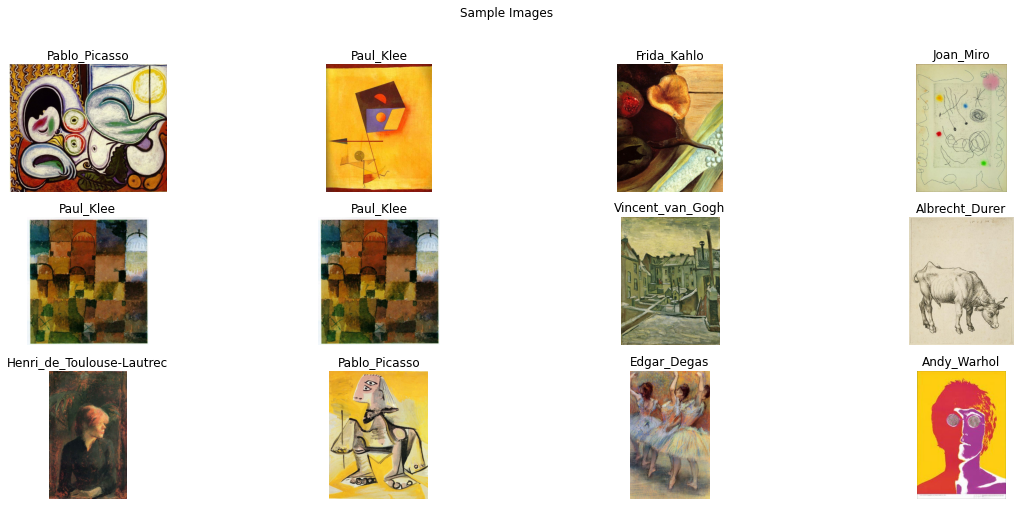

In [8]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(data_list)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(data_list[img_idx][0])
    # Read image
    image = cv2.imread(data_list[img_idx][1])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

In [9]:
# Compute dataset metrics
compute_dataset_metrics(data_list)

Dataset Metrics:
----------------
Label Counts:
Vincent_van_Gogh             877
Edgar_Degas                  702
Pablo_Picasso                439
Pierre-Auguste_Renoir        336
Albrecht_Durer               328
Paul_Gauguin                 311
Francisco_Goya               291
Rembrandt                    262
Alfred_Sisley                259
Titian                       255
Marc_Chagall                 239
Rene_Magritte                194
Amedeo_Modigliani            193
Paul_Klee                    188
Henri_Matisse                186
Andy_Warhol                  181
Mikhail_Vrubel               171
Sandro_Botticelli            164
Leonardo_da_Vinci            143
Peter_Paul_Rubens            141
Salvador_Dali                139
Hieronymus_Bosch             137
Pieter_Bruegel               134
Diego_Velazquez              128
Kazimir_Malevich             126
Frida_Kahlo                  120
Giotto_di_Bondone            119
Gustav_Klimt                 117
Raphael                     

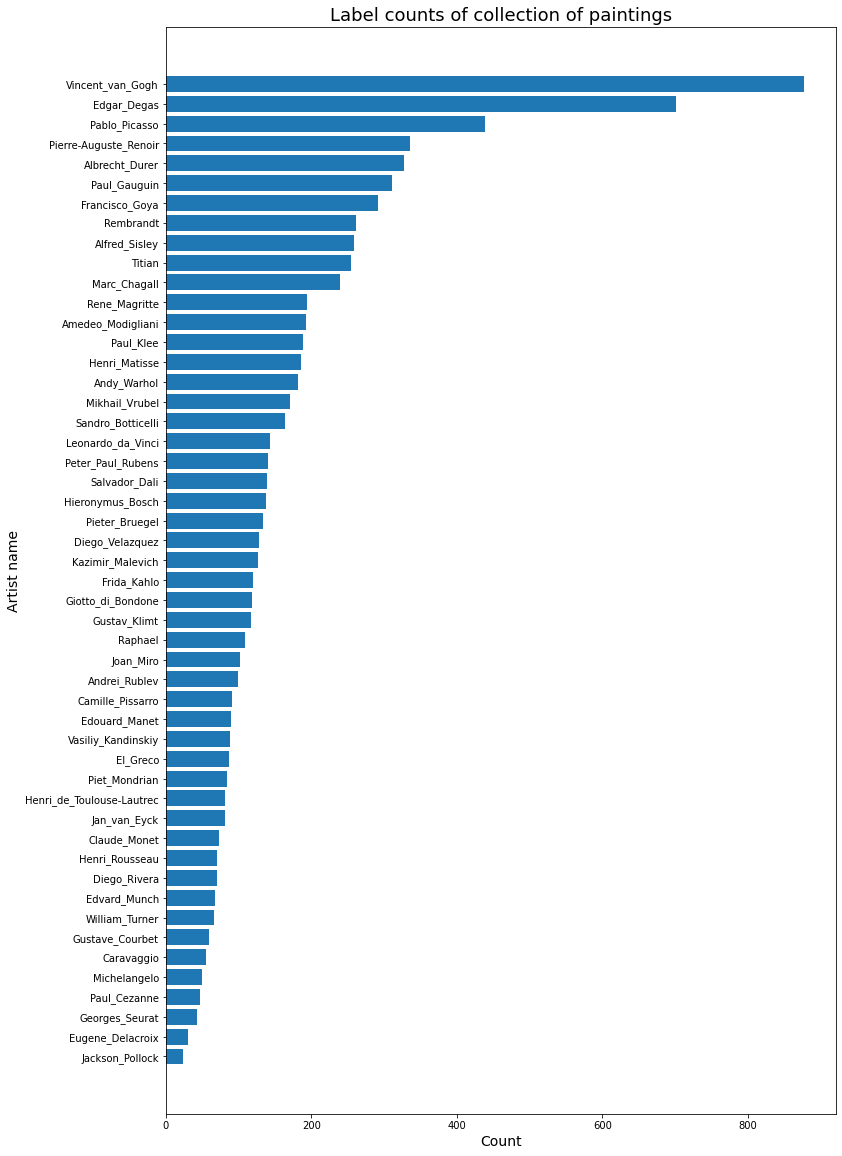

In [20]:
def dataset_metrics_visualization(data_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0], 
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })
  
  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  fig, ax = plt.subplots(figsize = (12,20))
  ax.barh(value_counts.index, value_counts)
  ax.set_title("Label counts of collection of paintings", fontsize=18)
  # ax.set_yticks(range(44))
  ax.set_xlabel("Count", fontsize=14)
  ax.set_ylabel("Artist name", fontsize=14)

  ax.invert_yaxis()

dataset_metrics_visualization(data_list)

#### **Data Pipelines**

In [10]:
data_x = [itm[1] for itm in data_list]
data_y = [itm[0] for itm in data_list]

print("data_x:",len(data_x))
print("data_y:",len(data_y))
print("data_x:",data_x[:5])
print("data_y:",data_y[:5])

data_x: 8446
data_y: 8446
data_x: ['./datasets/Vincent_van_Gogh/Vincent_van_Gogh_368.jpg', './datasets/Vincent_van_Gogh/Vincent_van_Gogh_473.jpg', './datasets/Vincent_van_Gogh/Vincent_van_Gogh_790.jpg', './datasets/Vincent_van_Gogh/Vincent_van_Gogh_221.jpg', './datasets/Vincent_van_Gogh/Vincent_van_Gogh_722.jpg']
data_y: ['Vincent_van_Gogh', 'Vincent_van_Gogh', 'Vincent_van_Gogh', 'Vincent_van_Gogh', 'Vincent_van_Gogh']


#### **TF Records**

In [11]:
import random

# Read TF Records
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64)
}

def create_tf_example(item):

  # Read image
  image = tf.io.read_file(item[1])
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  # # Encode
  # image = tf.cast(image, tf.uint8)
  # image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  image = tf.cast(image, tf.uint8)

  # Label
  label = label2index[item[0]]

  # Build feature dict
  feature_dict = {
      'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy().tobytes()])),
      'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
      'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[image_height])),
      'width': tf.train.Feature(int64_list=tf.train.Int64List(value=[image_width])),
  }

  example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
  return example

def create_tf_records(data,num_shards=10, prefix='', folder='data'):
  num_records = len(data)
  step_size = num_records//num_shards + 1

  for i in range(0, num_records, step_size):
    print("Creating shard:",(i//step_size)," from records:",i,"to",(i+step_size))
    path = '{}/{}_000{}.tfrecords'.format(folder, prefix, i//step_size)
    print(path)

    # Write the file
    with tf.io.TFRecordWriter(path) as writer:
      # Filter the subset of data to write to tfrecord file
      for item in data[i:i+step_size]:
        tf_example = create_tf_example(item)
        writer.write(tf_example.SerializeToString()) 

In [12]:
validation_percent = 0.2

# Split data into train / validate
train_xy, validate_xy = train_test_split(data_list, test_size=validation_percent)

print("train_xy count:",len(train_xy))
print("validate_xy count:",len(validate_xy))

train_xy count: 6756
validate_xy count: 1690


In [13]:
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32

# Create an output path to store the tfrecords
tfrecords_output_dir = "artists_tfrecords"
if os.path.exists(tfrecords_output_dir):
  shutil.rmtree(tfrecords_output_dir)
tf.io.gfile.makedirs(tfrecords_output_dir)

# Split data into multiple TFRecord shards between 100MB to 200MB
num_shards = 5

# Create TF Records for train
start_time = time.time()
create_tf_records(train_xy,num_shards=num_shards, prefix="train", folder=tfrecords_output_dir)
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

# Split data into multiple TFRecord shards between 100MB to 200MB
num_shards = 2

# Create TF Records for validation
start_time = time.time()
create_tf_records(validate_xy,num_shards=num_shards, prefix="val", folder=tfrecords_output_dir)
execution_time = (time.time() - start_time)/60.0
print("Execution time (mins)",execution_time)

Creating shard: 0  from records: 0 to 1352
artists_tfrecords/train_0000.tfrecords
Creating shard: 1  from records: 1352 to 2704
artists_tfrecords/train_0001.tfrecords
Creating shard: 2  from records: 2704 to 4056
artists_tfrecords/train_0002.tfrecords
Creating shard: 3  from records: 4056 to 5408
artists_tfrecords/train_0003.tfrecords
Creating shard: 4  from records: 5408 to 6760
artists_tfrecords/train_0004.tfrecords
Execution time (mins) 1.0692144513130188
Creating shard: 0  from records: 0 to 846
artists_tfrecords/val_0000.tfrecords
Creating shard: 1  from records: 846 to 1692
artists_tfrecords/val_0001.tfrecords
Execution time (mins) 0.25584105650583905


In [14]:
# Image augmentation
import albumentations as A
from functools import partial

augmentor_tr = A.Compose([
    A.HorizontalFlip(p=0.5),
    # A.augmentations.transforms.ShiftScaleRotate(scale_limit=0.5, p=0.4),
    # A.augmentations.transforms.RandomBrightnessContrast(p=0.4),
    # A.augmentations.transforms.Blur(p=0.3),
    # A.augmentations.transforms.Cutout(num_holes=30, p=0.3)
])

def aug(image):
    aug_img = augmentor_tr(image=image)['image']
    aug_img = tf.image.convert_image_dtype(aug_img, 'float32')
    return aug_img

def tf_augment(image,label):
    aug_img = tf.numpy_function(func = aug, inp =[image], Tout =tf.float32)
    return aug_img, label

In [15]:
train_shuffle_buffer_size= len(train_xy)
validation_shuffle_buffer_size= len(validate_xy)

# @tf.function
def parse_tfrecord_example(example_proto):
  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # Image
  #image = tf.image.decode_jpeg(parsed_example['image'])
  image = tf.io.decode_raw(parsed_example['image'], tf.uint8)
  image.set_shape([num_channels * image_height * image_width])
  image = tf.reshape(image, [image_height, image_width, num_channels])
  # Label
  label = tf.cast(parsed_example['label'], tf.int32)
  label = tf.one_hot(label, num_classes) #one hot encoding

  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  #image = keras.applications.mobilenet.preprocess_input(image)
  return image, label

# # Convert all y labels to numbers
# train_processed_y = [label2index[label] for label in train_y]
# validate_processed_y = [label2index[label] for label in validate_y]

# Read the tfrecord files
train_tfrecord_files = tf.data.Dataset.list_files(tfrecords_output_dir+'/train*')
validate_tfrecord_files = tf.data.Dataset.list_files(tfrecords_output_dir+'/val*')

#############
# Train data
#############
# Apply all data processing logic
train_data = train_tfrecord_files.flat_map(tf.data.TFRecordDataset)
train_data = train_data.map(parse_tfrecord_example, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(tf_augment,num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(AUTOTUNE)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validate_tfrecord_files.flat_map(tf.data.TFRecordDataset)
validation_data = validation_data.map(parse_tfrecord_example, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset shapes: (<unknown>, (None, 50)), types: (tf.float32, tf.float32)>
validation_data <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 50)), types: (tf.float32, tf.float32)>


In [16]:
for i in train_data.take(1):
  print(i)

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0.34509805, 0.34117648, 0.22352941],
         [0.49803922, 0.46666667, 0.32156864],
         [0.61960787, 0.5921569 , 0.42745098],
         ...,
         [0.8117647 , 0.8509804 , 0.69411767],
         [0.7137255 , 0.70980394, 0.49411765],
         [0.654902  , 0.6156863 , 0.42745098]],

        [[0.41568628, 0.40392157, 0.28235295],
         [0.6392157 , 0.62352943, 0.4862745 ],
         [0.6627451 , 0.6627451 , 0.52156866],
         ...,
         [0.8392157 , 0.88235295, 0.74509805],
         [0.70980394, 0.7058824 , 0.5254902 ],
         [0.56078434, 0.5254902 , 0.35686275]],

        [[0.4117647 , 0.4       , 0.2784314 ],
         [0.62352943, 0.627451  , 0.50980395],
         [0.6431373 , 0.6784314 , 0.56078434],
         ...,
         [0.5764706 , 0.62352943, 0.5176471 ],
         [0.7607843 , 0.7607843 , 0.6039216 ],
         [0.5764706 , 0.5411765 , 0.3882353 ]],

        ...,

        [[0.96862745, 0.98039216

#### **Training**

In [17]:
def build_mobilenetv2_model(image_height, image_width, num_channels, num_classes, train_base = False):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Handle to pretrained model
  handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        keras.layers.InputLayer(input_shape=input_shape),
        hub.KerasLayer(handle, trainable=train_base),
        keras.layers.Dense(units=64, activation='relu',
                               kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                               bias_regularizer=keras.regularizers.l1(bias_weight)),
        keras.layers.Dense(units=num_classes, activation='softmax',
                                  kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                                  bias_regularizer=keras.regularizers.l1(bias_weight))
  ],name='model_mobilenetv2_train_base_'+str(train_base))

  return model

In [18]:
############################
# Training Params
############################
learning_rate = 0.0003
initial_epoch = 0
epochs = 100

# lr scheduler
cosineLR = tf.keras.experimental.CosineDecayRestarts(1e-2, 20, alpha=0.01, t_mul=1.0, m_mul=0.75)
rlr_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.3, patience=3, mode='max', verbose=1)
cosineAR_cb = tf.keras.callbacks.LearningRateScheduler(cosineLR, verbose=1)

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=8)

CALLBACKS = [rlr_cb, early_stopping]

# Load pre trained model during demos
LOAD_PREV_TRAINED = False

# Free up memory
K.clear_session()

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1) # from_logits=True, 

# Build or Load Model
if not LOAD_PREV_TRAINED:
  # Build the teacher model
  mobilenet_model = build_mobilenetv2_model(image_height, image_width, num_channels, num_classes, train_base = True)
  print(mobilenet_model.summary())

  # Compile
  mobilenet_model.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.CategoricalAccuracy()])
  
else:
  # Load model
  mobilenet_model = keras.models.load_model("mobilenet_model/mobilenet_model.hdf5", custom_objects={'KerasLayer':hub.KerasLayer})
  print(mobilenet_model.summary())


  with open("mobilenet_model/mobilenet_model_train_history.json") as json_file:
    prev_training_history = json.load(json_file)
  with open("mobilenet_model/mobilenet_model_model_metrics.json") as json_file:
    model_metrics = json.load(json_file)

  epochs = len(prev_training_history["loss"])
  initial_epoch=epochs
  epochs=epochs+3 # Continue training for a few more epochs


# Train model
start_time = time.time()
training_results = mobilenet_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=(CALLBACKS),
        verbose=2)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

if LOAD_PREV_TRAINED:
  # Append previous training history & time
  training_history = append_training_history(training_results.history,
                                             prev_training_history,
                                             metrics=["loss","val_loss","categorical_accuracy","val_categorical_accuracy"])
  execution_time = model_metrics["execution_time"] + execution_time


Model: "model_mobilenetv2_train_base_True"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3250      
Total params: 2,343,218
Trainable params: 2,309,106
Non-trainable params: 34,112
_________________________________________________________________
None
Epoch 1/100
212/212 - 60s - loss: 30.3336 - categorical_accuracy: 0.3555 - val_loss: 9.1792 - val_categorical_accuracy: 0.3834
Epoch 2/100
212/212 - 38s - loss: 6.9530 - categorical_accuracy: 0.3672 - val_loss: 5.7127 - val_categorical_accuracy: 0.3467
Epoch 3/100
212/212 - 38s - loss: 4.7479 - categorical_accuracy: 0.3850 - val_loss: 4.2664

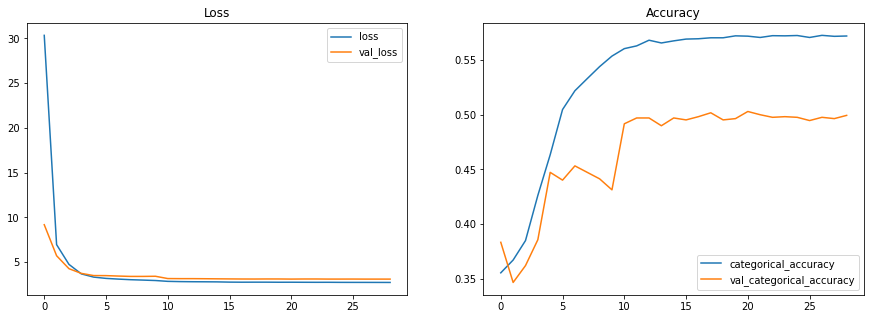

53/53 [==============================] - 1s 24ms/step - loss: 3.1012 - categorical_accuracy: 0.4994
{'loss': 3.1012065410614014, 'categorical_accuracy': 0.4994082748889923}


In [19]:
# Evaluate model
evaluation_results = evaluate_model(mobilenet_model,validation_data, 
               training_history,execution_time,learning_rate, batch_size, epochs, optimizer,
               save=True,
               loss_metrics=["loss","val_loss"],
               acc_metrics=["categorical_accuracy","val_categorical_accuracy"])

# Save student model
save_model(mobilenet_model,training_history,execution_time,learning_rate, epochs, optimizer, evaluation_results)